In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statistics

import data_cleaning

# Data loading / cleaning

## Loading..

In [2]:
#POAP data
poap = data_cleaning.get_cleaned_poap_data()

#DAOHaus data
dh_members, dh_proposals, dh_votes = data_cleaning.get_daohaus_cleaned_data()

#Snapshot data
snap_proposals, snap_votes, snap_creation = data_cleaning.get_snapshot_cleaned_data()

In [6]:
poap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3685249 entries, 0 to 3705199
Data columns (total 26 columns):
token_created          int64
event_created          int64
event_id               int64
event_tokenCount       int64
event_transferCount    int64
token_id               int64
owner_id               object
token_transferCount    int64
chain                  object
event_fancy_id         object
event_name             object
event_url              object
event_image_url        object
event_country          object
event_city             object
event_description      object
event_year             int64
event_start_date       object
event_end_date         object
event_expiry_date      object
event_from_admin       bool
virtual_event          bool
event_template_id      int64
event_host_id          int64
private_event          bool
owner_id_checksum      object
dtypes: bool(3), int64(10), object(13)
memory usage: 685.3+ MB


In [10]:
from datetime import datetime

#creating mint dates
poap['mint_timestamp'] = poap['token_created'].apply(lambda t: datetime.fromtimestamp(t) )
poap['mint_date'] = poap['mint_timestamp'].dt.date
poap['mint_year'] = poap['mint_timestamp'].dt.year

poap.head()

,token_created,event_created,event_id,event_tokenCount,event_transferCount,token_id,owner_id,token_transferCount,chain,event_fancy_id,...,event_expiry_date,event_from_admin,virtual_event,event_template_id,event_host_id,private_event,owner_id_checksum,mint_timestamp,mint_date,mint_year
0,1558995074,1558995074,14,84,96,1,0xea5ce2f9a33d36534ee3409d81322feb3f91ed8a,1,ethereum,ethdenver-19,...,19-Mar-2019,True,False,0,0,False,0xeA5ce2F9a33D36534eE3409D81322feb3F91ED8a,2019-05-27 16:11:14,2019-05-27,2019
1,1558995074,1558995074,14,84,96,10,0xa3f0d54a263520375e01c17b8ffbd3190745bbd9,1,ethereum,ethdenver-19,...,19-Mar-2019,True,False,0,0,False,0xA3F0d54A263520375E01C17B8ffBD3190745BbD9,2019-05-27 16:11:14,2019-05-27,2019
2,1558999607,1558999607,4,28,29,100,0x68f9d801c96ac6ccf562f3600cef77c4504449b6,1,ethereum,devcon2,...,21-Oct-2016,True,False,0,0,False,0x68F9D801C96aC6ccf562f3600Cef77c4504449b6,2019-05-27 17:26:47,2019-05-27,2019
3,1559020637,1559018257,28,316,334,1000,0xdd6f702c2907ce401888d993d7dc185e7a824466,1,ethereum,ethny-19,...,19-Jun-2019,True,False,0,0,False,0xDd6f702C2907ce401888D993D7Dc185e7a824466,2019-05-27 23:17:17,2019-05-27,2019
4,1588548343,1588539431,207,1197,1211,10000,0xcc95fd73c77bb7bb58714688e9333c05a388693e,1,ethereum,virtual-blockchain-week-2020-general-2020,...,02-Jun-2020,False,False,0,0,False,0xcC95fd73C77bB7BB58714688e9333c05A388693e,2020-05-03 17:25:43,2020-05-03,2020


# Analysis

## How many POAP are issued per year

**Different events created**

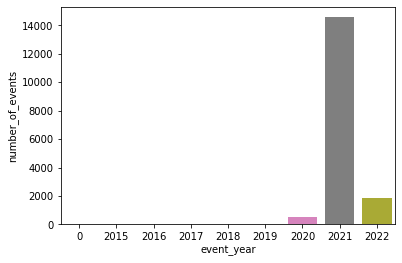

In [11]:
ev = poap.groupby('event_year').agg(number_of_events=('event_id', 'nunique')).reset_index()

sns.barplot(data=ev, x='event_year', y='number_of_events')

**Number of tokens minted**

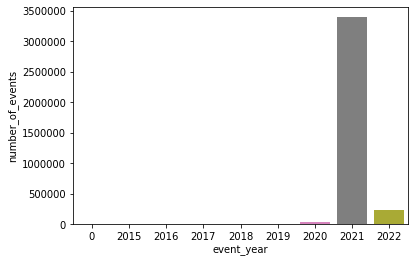

In [12]:
ev = poap.groupby('event_year').agg(number_of_events=('token_id', 'nunique')).reset_index()

sns.barplot(data=ev, x='event_year', y='number_of_events')

### Relatioship with ETH price

In [38]:
# got historical price data from here: https://ca.investing.com/crypto/ethereum/eth-usd-historical-data

custom_date_parser = lambda x: datetime.strptime(x, '%b %d, %Y')
ethprice = pd.read_csv('eth_usd_historical_prices.csv', thousands=',', parse_dates=['Date'], date_parser=custom_date_parser)
ethprice.head(2)

,Date,Price,Open,High,Low,Vol.,Change %
0,2022-02-21,2744.69,2621.87,2748.69,2608.33,438.68K,4.81%
1,2022-02-20,2618.76,2764.39,2764.39,2577.69,386.43K,-5.25%


In [50]:
#getting daily mints
dmints = poap.groupby('mint_date').agg(number_of_mints=('token_id', 'nunique')).reset_index()
dmints['mint_date_adj'] = pd.to_datetime(dmints['mint_date'], infer_datetime_format=True)
dmints.head()

#changing price columns name
ethprice = ethprice.rename(columns={'Price':'eth_price_USD'})

dmints = dmints.merge(ethprice.loc[:, ['Date', 'eth_price_USD']], left_on='mint_date_adj', right_on='Date', how='left')

dmints.head()

,mint_date,number_of_mints,mint_date_adj,Date,eth_price_USD
0,2019-05-27,871,2019-05-27,2019-05-27,270.88
1,2019-05-30,8,2019-05-30,2019-05-30,254.63
2,2019-05-31,3,2019-05-31,2019-05-31,268.01
3,2019-06-13,4,2019-06-13,2019-06-13,254.80
4,2019-06-21,5,2019-06-21,2019-06-21,294.63


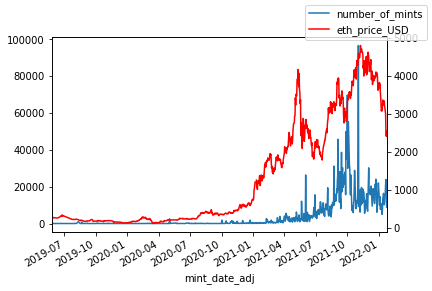

In [51]:
ax = dmints.plot(x="mint_date_adj", y="number_of_mints", legend=False)
ax2 = ax.twinx()
dmints.plot(x="mint_date_adj", y="eth_price_USD", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

## Median Number of attendees

In [19]:
mev = poap.groupby(['event_id', 'event_year']).agg(n_attendees=('owner_id', 'nunique')).reset_index()
mevg = mev.groupby('event_year').agg(avg_n_attendees=('n_attendees', 'mean')).reset_index()

mevg

,event_year,avg_n_attendees
0,0,8.000000
1,2015,12.000000
2,2016,128.500000
3,2017,54.000000
4,2018,27.647059
5,2019,86.055556
6,2020,92.318275
7,2021,231.060625
8,2022,130.819068


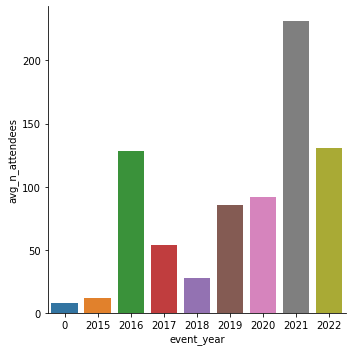

In [21]:
sns.catplot(data=mevg, x='event_year', y='avg_n_attendees', kind='bar')

## How many issuers